Gene expression data analysis
=============================

This notebook demonstrates analysis of a gene expression data set.  The data set contains gene expression measurements on thousands of genes for subjects who have one of two gastrointestinal diseases -- ulcerative colitis and Crohn's disease.

The data are available from the NCBI Gene Expression Omnibus (GEO) site, at the following link:

http://www.ncbi.nlm.nih.gov/sites/GDSbrowser?acc=GDS1615

First we import the libraries that we will be using.

In [1]:
%matplotlib inline

import gzip
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm, t as t_dist

### Reading the data

The data are stored in a format called SOFT.  We will need to write a fair amount of code to extract the data.  First we open the file, which is gzipped.

In [2]:
fname = "GDS1615_full.soft.gz"
fid = gzip.open(fname, 'rt')

Next we extract some information about the subjects from the upper part of the file.  The dictionary called `group` maps each subject's id to a string giving the disease group for that subject.

In [3]:
dx = {}
for line in fid:

    if line.startswith("!dataset_table_begin"):
        break
    elif line.startswith("!subset_description"):
        subset_description = line.split("=")[1].strip()
    elif line.startswith("!subset_sample_id"):
        subset_ids = line.split("=")[1].split(",")
        subset_ids = [x.strip() for x in subset_ids]
        for k in subset_ids:
            dx[k] = subset_description

print({k: dx[k] for k in list(dx.keys())[0:10]})

{'GSM76041': 'ulcerative colitis', 'GSM76048': 'ulcerative colitis', 'GSM76049': 'ulcerative colitis', 'GSM76044': 'ulcerative colitis', 'GSM76045': 'ulcerative colitis', 'GSM76103': "Crohn's disease", 'GSM76047': 'ulcerative colitis', 'GSM76040': 'ulcerative colitis', 'GSM76046': 'ulcerative colitis', 'GSM76042': 'ulcerative colitis'}


The next line in the file contains the column headers (sample id's), in the same order that the gene expression values are stored in the data table (to be read later).

In [4]:
subject_ids = next(fid).rstrip().split("\t")
print(subject_ids[0:10])

['ID_REF', 'IDENTIFIER', 'GSM76115', 'GSM76116', 'GSM76117', 'GSM76118', 'GSM76119', 'GSM76120', 'GSM76121', 'GSM76122']


The column labels that start with "GSM" contain gene expression data.  We want to have the indices of those columns so we can easily select them when reading the table.

In [5]:
data_ix = [i for i,x in enumerate(subject_ids) if x.startswith("GSM")]
print(data_ix[0:10])

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


We restrict the column headers to those that correspond to gene expression data.

In [6]:
subject_ids = [subject_ids[i] for i in data_ix]
print(subject_ids[0:10])

['GSM76115', 'GSM76116', 'GSM76117', 'GSM76118', 'GSM76119', 'GSM76120', 'GSM76121', 'GSM76122', 'GSM76123', 'GSM76124']


Next we construct a list containing the disease groups in the same order that the columns appear in the data file.

In [7]:
dx_col = [dx[k] for k in subject_ids]
print(dx_col[0:10])

['normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal']


Next we read the gene expression data into a list of lists.  Each row in the gene expression data table contains the data for one gene.  We store the name of this gene in the list `gene_id`.

In [8]:
gene_id, data = [], []
for line in fid:

    # This is what signals the end of the gene expression data
    # section of the file
    if line.startswith("!dataset_table_end"):
        break

    v = line.rstrip().split("\t")

    # Extract the values that correspond to gene expression measures
    # and convert the strings to numbers
    x = [float(v[i]) for i in data_ix]

    data.append(x)
    gene_id.append(v[0] + ";" + v[1])

Now we can convert the Python list of lists to a Numpy array.

In [9]:
data = np.array(data)
print(data[0:5, 0:3])

[[  80.7287    62.9846    61.6711 ]
 [  25.9926    22.6722    24.4851 ]
 [  49.5371    70.3211    64.5038 ]
 [ 312.482    277.637    216.865  ]
 [   3.40176   20.033      8.08134]]


These are the indices of samples for the ulcerative colitis group.

In [10]:
uc_ix = [i for i,x in enumerate(dx_col) if x == "ulcerative colitis"]
print(len(uc_ix))
print(uc_ix[0:10])

26
[42, 43, 44, 45, 46, 47, 48, 49, 50, 51]


These are the indices of samples in the Crohn's disease group.

In [11]:
cd_ix = [i for i,x in enumerate(dx_col) if x == "Crohn's disease"]
print(len(cd_ix))
print(cd_ix[0:10])

59
[68, 69, 70, 71, 72, 73, 74, 75, 76, 77]


## Differential expression analysis

Gene expression data is very skewed, so it is usually analyzed on the log scale.

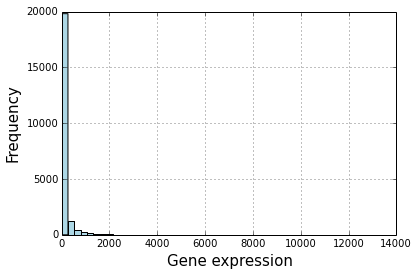

In [12]:
plt.clf()
_ = plt.hist(data[:, 0], bins=50, color='lightblue')
plt.grid(True)
plt.xlabel("Gene expression", size=15)
plt.ylabel("Frequency", size=15)

In [13]:
data_l = np.log(data) / np.log(2)

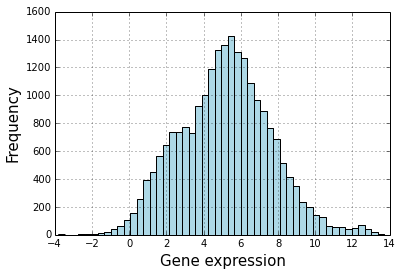

In [14]:
plt.clf()
_ = plt.hist(data_l[:, 0], bins=50, color='lightblue')
plt.grid(True)
plt.xlabel("Gene expression", size=15)
plt.ylabel("Frequency", size=15)

We will compare the mean of each gene between the Crohn's disease and ulcerative colitis groups.  To do this, we will need the mean and the variance for each gene within each disease group.

In [15]:
uc_m = data_l[:, uc_ix].mean(1) # Mean of ulcerative colitis samples
cd_m = data_l[:, cd_ix].mean(1) # Mean of Crohn's disease samples
uc_v = data_l[:, uc_ix].var(1)  # Variance of ulcerative colitis samples
cd_v = data_l[:, cd_ix].var(1)  # Variance of Crohn's disease samples
uc_n = len(uc_ix)               # Number of ulcerative colitis samples
cd_n = len(cd_ix)               # Number of Crohn's disease samples

The Z-score is a statistic that compares the means between two groups.  If the true means are equal, then the Z-scores follow a standardized (zero mean, unit variance) distribution that is approximately Gaussian.

In [16]:
zscore = (uc_m - cd_m) / np.sqrt(uc_v / uc_n + cd_v / cd_n)
print(zscore.std())

1.50181311998


We can improve the standardization of the Z-scores slightly by accounting for the uncertainty in estimating the scale parameters.  First we estimate the scale parameters.

(26, 59)

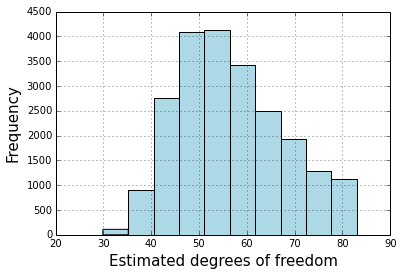

In [17]:
df = (uc_v / uc_n + cd_v / cd_n)**2 / (uc_v**2 / (uc_n**2 * (uc_n - 1)) + cd_v**2 / (cd_n**2 * (cd_n - 1)))

_ = plt.hist(df, color='lightblue')
plt.xlabel("Estimated degrees of freedom", size=15)
plt.ylabel("Frequency", size=15)
plt.grid(True)
len(uc_ix), len(cd_ix)

Now we use a Student-t model for the Z-scores to do the adjustment.

In [18]:
t_quantiles = t_dist.cdf(zscore, df)
zscore = norm.ppf(t_quantiles)
print(zscore.std())

1.4528115322


We can get a rough sense of how strong the effects are by looking at the mean and standard deviation of the Z-scores.  Since the standard deviation is much greater than 1, there are many genes with different mean expression in the two groups.  We can visualize the overdispersion of Z-scores by superimposing a standard normal density on the observed Z-score distribution.

0.169223244264


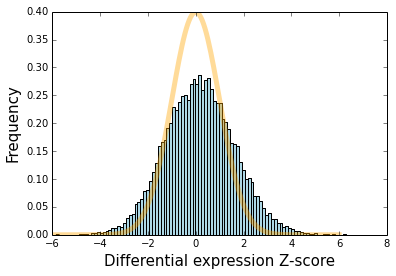

In [19]:
print(zscore.mean())
_ = plt.hist(zscore, bins=100, color='lightblue', normed=True)
plt.xlabel("Differential expression Z-score", size=15)
plt.ylabel("Frequency", size=15)

x = np.linspace(-6, 6, 200)
y = np.exp(-x**2/2) / np.sqrt(2*np.pi)
plt.plot(x, y, '-', lw=5, color='orange', alpha=0.4)

To get an overall picture of how strong the effects are, we can make a normal quantile plot of the Z-scores.  Since the deviation from the standard null holds throughout the range of the data, either the effects are not sparse, or there is some miscalibration in the Z-scores.

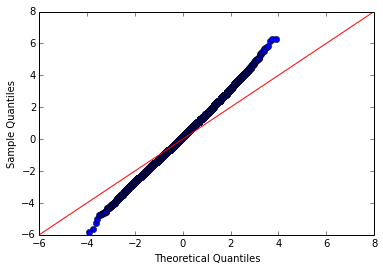

In [28]:
import statsmodels.api as sm
_ = sm.qqplot(zscore, line='45')

Next we will calculate False Discovery Rates (FDR values) for each gene.  To do this, we fist need to convert the Z-scores to p-values.

In [21]:
from scipy.stats.distributions import norm
pvalues = 2*norm.cdf(-np.abs(zscore))

22283
152
39


['222131_x_at;RHOT2',
 '211430_s_at;IGHV4-31',
 '211643_x_at;LOC100510044',
 '211074_at;FOLR1',
 '218381_s_at;U2AF2',
 '206019_at;RBM19',
 '215176_x_at;IGK',
 '214676_x_at;MUC3A',
 '214649_s_at;MTMR2',
 '221651_x_at;IGK',
 '211881_x_at;IGLJ3',
 '214836_x_at;IGK',
 '221671_x_at;IGK',
 '214669_x_at;IGKC',
 '207621_s_at;PEMT',
 '208179_x_at;KIR2DL3',
 '220496_at;CLEC1B',
 '211644_x_at;IGK',
 '217944_at;POMGNT1',
 'AFFX-M27830_M_at;--Control']

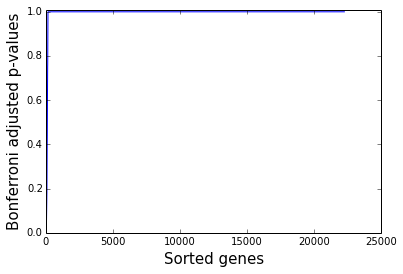

In [30]:
print len(pvalues)
bonf_pvalues = pvalues * len(pvalues)
bonf_pvalues[bonf_pvalues > 1] = 1
print sum(bonf_pvalues < 1)
print sum(bonf_pvalues < 0.05)
ii = np.argsort(bonf_pvalues)

plt.clf()
plt.plot(bonf_pvalues[ii], '-')
plt.xlabel("Sorted genes", size=15)
plt.ylabel("Bonferroni adjusted p-values", size=15)
plt.ylim(0, 1.01)
[gene_id[i] for i in ii[0:20]]

Next we calculate the FDR values, using the Benjamini-Hochberg approach.

In [23]:
from statsmodels.sandbox.stats.multicomp import multipletests

_, fdr, _, _ = multipletests(pvalues, method='fdr_bh')

ii = np.argsort(fdr)
fdr_s = fdr[ii]
pvalues_s = pvalues[ii]

FDR values are not directly comparable to p-values, except to the extent that they are both probabilities.  The FDR values tend to be larger than the p-values.

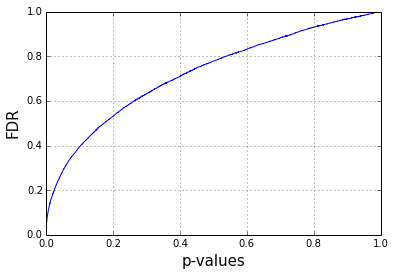

In [24]:
plt.plot(pvalues_s, fdr_s, '-')
plt.grid(True)
plt.xlabel("p-values", size=15)
plt.ylabel("FDR", size=15)

Here we zoom in a bit on the region of the plot where the small p-values and FDR values are located.

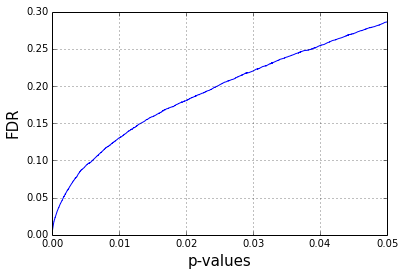

In [25]:
plt.plot(pvalues_s, fdr_s, '-')
plt.grid(True)
plt.xlim(0, 0.05)
plt.ylim(0, 0.3)
plt.xlabel("p-values", size=15)
plt.ylabel("FDR", size=15)

The following plot shows the sorted FDR values.  Out of >20,000 genes, it appears that around 2,000 have strong evidence of differential expression (FDR < 0.1).

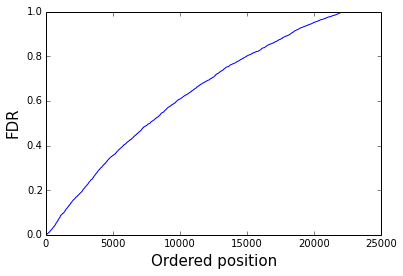

In [26]:
plt.plot(fdr_s)
plt.xlabel("Ordered position", size=15)
plt.ylabel("FDR", size=15)

To get a better sense of how strong the differential expression is, we can make boxplots of the two groups for genes with different FDR values.

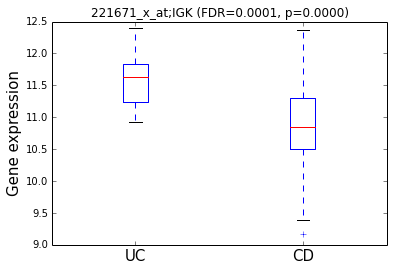

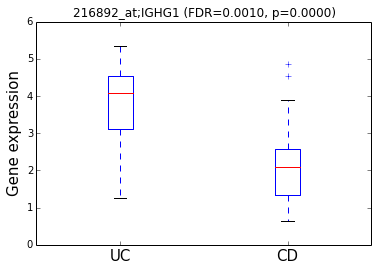

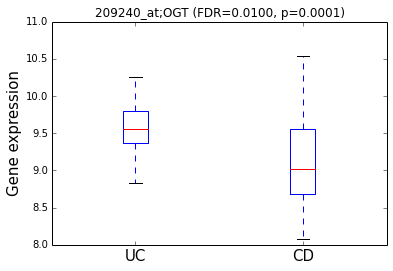

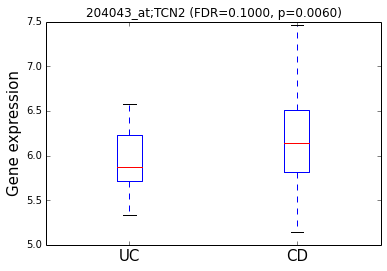

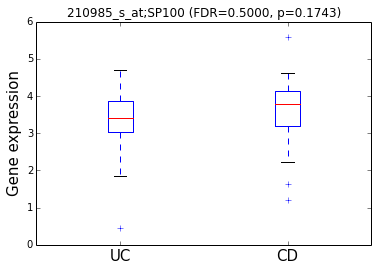

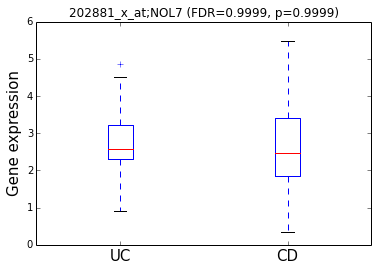

In [27]:
for f in [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0]:
    ii = np.argmin(np.abs(fdr - f))
    plt.figure()
    plt.boxplot((data_l[ii, uc_ix], data_l[ii, cd_ix]))
    plt.gca().set_xticklabels(("UC", "CD"), (1, 2), size=15)
    plt.ylabel("Gene expression", size=15)
    plt.title("%s (FDR=%.4f, p=%.4f)" % (gene_id[ii], fdr[ii], pvalues[ii]))

### Exercises

* Identify the genes that would be deemed to have statistically significant differential expression using a Bonferroni correction for multiple testing (just multiply every p-value by the number of tested genes).

* Repeat the differential expression by stratifying the genes on the mean expression.  Then do the same thing when stratifying on the standard deviation of gene expression.

* The data file also contains data from normal controls.  Carry out a differential expression comparison between each of the two disease groups and the normal controls, using methods such as are used above.